In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import json
import re
import scipy as sp
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax
from scipy.sparse import csr_matrix


import warnings
warnings.filterwarnings('ignore')

import random
random.seed(1234)

# Data Loading and Processing

In [11]:
data_dir = '/Users/dare_devil/Documents/MLDS_2024/Quarter2/DataMining/Project/data'
os.listdir(data_dir)

['test_data.json',
 'user_profiles_bert.pkl',
 '.DS_Store',
 'dataset',
 'user_profiles.pkl',
 'item_profiles_bert.pkl',
 'test_df_filtered.json',
 '.ipynb_checkpoints',
 'train_data.json',
 'archive.zip',
 'item_profiles.pkl']

In [12]:
# Filenames of the objects to be used

## Train and Test Data File Names
train_data_fname = 'train_data.json'
test_data_fname = 'test_data.json'

## User Profiles and Item Profiles Names
user_profiles_fname = 'user_profiles.pkl'
item_profiles_fname = 'item_profiles.pkl'

In [13]:
# Loading Data

## loading train and test data
train_df = pd.read_json(os.path.join(data_dir, train_data_fname))
test_df = pd.read_json(os.path.join(data_dir, test_data_fname))

## Loading user and item profiles
user_profiles = pickle.load(open(os.path.join(data_dir, user_profiles_fname), 'rb'))
item_profiles = pickle.load(open(os.path.join(data_dir, item_profiles_fname), 'rb'))

In [27]:
## Defining User, Item Matrices and Mapping Functions
user_matrix = np.array([profile  for user_id, profile in user_profiles.items()])
item_matrix = np.array([profile  for item_id, profile in item_profiles.items()])

idx2user = { idx:user_id for idx,user_id in enumerate(user_profiles.keys())}
idx2item = { idx:item_id for idx,item_id in enumerate(item_profiles.keys())}

In [28]:
## Removing items from test set which are not present in train set
test_items = test_df['business_id'].unique()
train_items = train_df['business_id'].unique()

delete_items = []
for item in test_items:
  if item not in train_items:
    delete_items.append(item)


print(test_df.shape)
test_df = test_df[~test_df.business_id.isin(delete_items)]
print(test_df.shape)

print(f"Deleted Items: {len(delete_items)}")

(67278, 22)
(67101, 22)
Deleted Items: 164


In [29]:
# Filtering Test Dataframe based on number of reviews per user
# Only allow those users, who have num of reviews >= 50
review_per_user_thresh = 50  

# Getting User vs Number of Reviews Dataframe
user_review_count = test_df.groupby('user_id')['review_id'].count().sort_values(ascending=False).reset_index()
user_review_count.rename(columns={'review_id' : 'num_reviews'}, inplace=True)

# Filtering users based on review_per_user_thresh
filtered_user_ids = user_review_count[user_review_count.num_reviews >= review_per_user_thresh].user_id

test_df_filtered = test_df[test_df.user_id.isin(filtered_user_ids)]
print("Filtered Test Dataframe Size :", test_df_filtered.shape[0])

Filtered Test Dataframe Size : 6832


In [30]:
# Defining Helper Functions
def evaluate_engine(test_df, topk, engine):
    """
    Given a topk value, test_df and engine, evaluate the recommender engine using mse and mae criteria
    args:
        test_df : test dataframe
        topk : topk similar users/items to use to predict rating of a new item
        engine : recommendation engine to be evaluated
    returns:
        mse : mean sqaured error of the recommender engine
        mae : mean absolute error of the recommender engine
    """
    # Ground Truth Rating of user-item pair
    y_true = np.array(test_df['user_rating'].tolist())
    y_pred = []
    
    failed_indices = []
    done=0
    total=test_df.shape[0]
    
    print("Starting Inference")
    for idx, row in test_df.iterrows():
        u_id = row['user_id']
        item_id = row['business_id']
        try:
            pred_rating = engine.predict(u_id, item_id, topk)
        except Exception as e:
            print(e)
            failed_indices.append(idx)
            continue
        y_pred.append(pred_rating)
        done+=1
        if done % 500 == 0:
            print(f"{done}/{total} Done | {len(failed_indices)}/{total} Failed")
    
    print("Removing Failed Indices")
    y_true = np.delete(y_true, failed_indices)

    # Calculating performance metrics 
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"mse@k={topk} : {mse}, mae@k={topk} : {mae}")
    print("Done")
    return mse, mae

# Recommmendation System Development

## User Based Recommendation System

In [32]:
# Defining User Based Recommendation Engine Class
class UserBasedEngine:
    """
    UserBased RS class. Works by finding similar users who have rated the given item and compute the ratings
    """
    def __init__(self, sim_matrix, idx2user, idx2item, train_df):
        """
        args:
          sim_matrix: user-user similarity matrix
          idx2user : index to user_id mapping
          idx2item : index to item_id mapping
          train_df : training dataframe
        """
        self.sim_matrix = sim_matrix
        self.idx2user = idx2user
        self.idx2item = idx2item
        self.train_df = train_df
    
        self.user2idx = {v:k for k,v in self.idx2user.items()}
        self.item2idx = {v:k for k,v in self.idx2item.items()}
        
    def predict(self, user_id, item_id, topk):
        """
        Given a user_id,item_id find users who have rated given item_id and find topk similar users
        args:
          user_id, item_id : pair of user_id and item_id for which rating is to predicted
          topk : number of nearest neighbours to consider
        """
        # Finding users who have rated item : item_id
        user_who_rated = self.train_df[self.train_df.business_id == item_id].user_id.unique()
    
        user_index = self.user2idx[user_id]
        sim_scores = self.sim_matrix[user_index]
    
        sim_scores = pd.Series(sim_scores)
        sim_scores.index = self.user2idx.keys()
    
        # Finding Similar users as user_id from the users who have rated
        sorted_sim_scores = sim_scores[user_who_rated].sort_values(ascending=False)
    
        # Appplying Softmax of Similarity scores
        topk_sims = softmax(sorted_sim_scores[:topk])
        topk_users = sorted_sim_scores[:topk].index
    
        filter_df = self.train_df[(self.train_df.business_id == item_id) & (self.train_df.user_id.isin(topk_users))]
        topk_ratings = [user_df['user_rating'].mean() for user_id, user_df in filter_df.groupby('user_id')]
    
        # Calculate weighted predicted rating
        predicted_rating = round(sum([ topk_sims[idx]*topk_ratings[idx] for idx in range(len(topk_ratings))]))
    
    
        assert predicted_rating >= 0.99 and predicted_rating <= 5.1, f"Predicted Rating : {predicted_rating} out of bounds"
        return predicted_rating

In [33]:
# Initializinng User Similarity Matrix
user_sim_matrix = cosine_similarity(user_matrix)
np.fill_diagonal(user_sim_matrix, 0)


# Initializing User Based Engine
ub_engine = UserBasedEngine(sim_matrix=user_sim_matrix,
                            idx2user = idx2user,
                            idx2item = idx2item,
                            train_df = train_df
                            )

In [63]:
# Running User Based Engine on Different values of topk to find best mse and mae
KRange = [5, 10, 15, 20, 25]
mse_list = []
mae_list = []

for topk in KRange:
  print(f"Evaluating for topk = {topk}")
  mse, mae = evaluate_engine(test_df = test_df_filtered,
                             topk = topk,
                             engine = ub_engine
                             )
  mse_list.append(mse)
  mae_list.append(mae)

Evaluating for topk = 5
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indices
mse@k=5 : 0.9217164847158762, mae@k=5 : 0.7408700312473461
Done
Evaluating for topk = 10
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indic

Text(0.5, 1.0, 'MSE vs TopK')

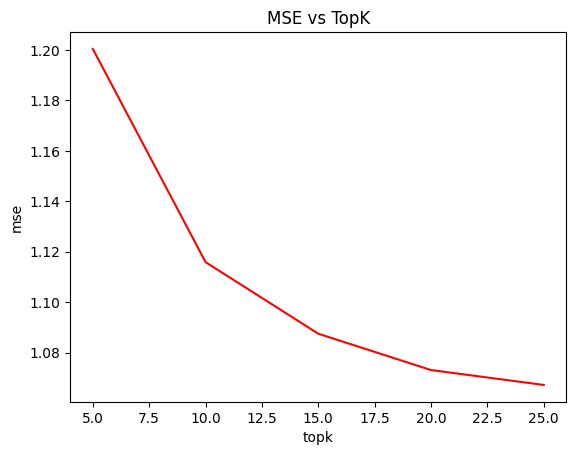

In [16]:
# Plotting MSE vs Topk Curve
plt.plot(KRange, mse_list, color='r')
plt.xlabel('topk')
plt.ylabel('mse')
plt.title('MSE vs TopK')

Text(0.5, 1.0, 'MAE vs TopK')

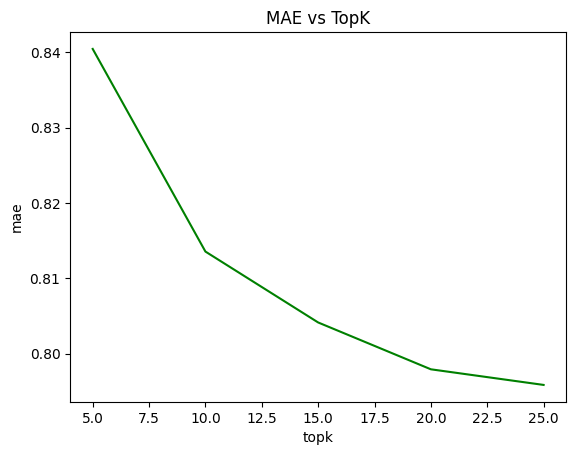

In [17]:
# Plotting MAE vs TopK Curve
plt.plot(KRange, mae_list, color='g')
plt.xlabel('topk')
plt.ylabel('mae')
plt.title('MAE vs TopK')

**Conclusion**

- Due to computation expense, we can not choose too high of K value. From the above plots, the optimal value of topk selected is 20
- **mse@k=20** : 0.7864, **mae@k=20** : 0.6884



## Item Based Recommendation System

In [34]:
class ItemBasedEngine:
  def __init__(self, sim_matrix, idx2user, idx2item, train_df):
    """
    params:
      sim_matrix : item-item similarity matrix
      idx2user : mapping of index to user_id
      idx2item : mapping of index to item_id
      train_df : training dataframe
    """
    self.sim_matrix = sim_matrix
    self.idx2user = idx2user
    self.idx2item = idx2item
    self.train_df = train_df

    self.user2idx = {v:k for k,v in self.idx2user.items()}
    self.item2idx = {v:k for k,v in self.idx2item.items()}

  def predict(self, user_id, item_id, topk):
    """
    Given a user_id,item_id find similar item that user has alreay used to compute the rating of the given item
    args:
        user_id : input user_id
        item_id : input item_id
        topk    : nearest neighbours to consider to compute the rating
    return:
        predicted_rating
    """
    # Finding Items given user has rated
    items_user_has_rated = self.train_df[self.train_df.user_id == user_id].business_id.unique()

    item_index = self.item2idx[item_id]
    sim_scores = self.sim_matrix[item_index]

    sim_scores = pd.Series(sim_scores)
    sim_scores.index = self.item2idx.keys()

    # Finding similarity of the given item with the items that user has rated
    sorted_sim_scores = sim_scores[items_user_has_rated].sort_values(ascending=False)

    topk_sims = softmax(sorted_sim_scores[:topk])
    topk_items = sorted_sim_scores[:topk].index

    filter_df = self.train_df[(self.train_df.user_id == user_id) & (self.train_df.business_id.isin(topk_items))]
    topk_ratings = [item_df['user_rating'].mean() for item_id, item_df in filter_df.groupby('business_id')]

    predicted_rating = sum([ topk_sims[idx]*topk_ratings[idx] for idx in range(len(topk_ratings))])
    assert predicted_rating >= 0.9 and predicted_rating <= 5.2, f"Predicted Rating : {predicted_rating} out of bounds"

    return predicted_rating

In [35]:
# Initializinng Item Similarity Matrix
item_sim_matrix = cosine_similarity(item_matrix)
np.fill_diagonal(item_sim_matrix, 0)

# Initializng the Item Based Engine
ib_engine = ItemBasedEngine(sim_matrix=item_sim_matrix,
                            idx2user = idx2user,
                            idx2item = idx2item,
                            train_df = train_df
                            )

In [66]:
# Running Item Based Engine on Different values of topk to find best mse and mae
KRange = [5, 10, 15, 20, 25]
mse_list = []
mae_list = []

for topk in KRange:
  print(f"Evaluating for topk = {topk}")
  mse, mae = evaluate_engine(test_df = test_df_filtered,
                             topk = topk,
                             engine = ib_engine
                             )
  mse_list.append(mse)
  mae_list.append(mae)

Evaluating for topk = 5
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indices
mse@k=5 : 0.9457607474542407, mae@k=5 : 0.7485076953918329
Done
Evaluating for topk = 10
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indic

Text(0.5, 1.0, 'MSE vs TopK')

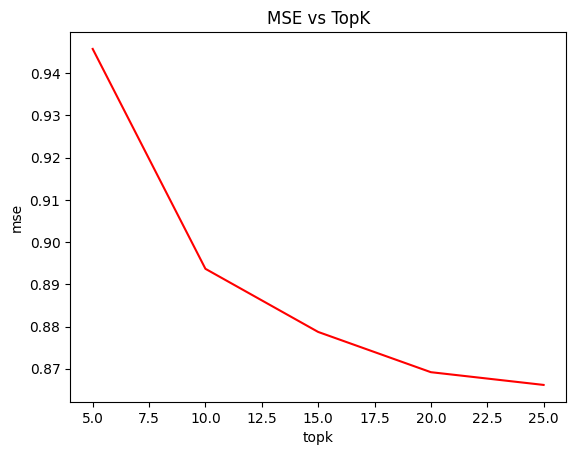

In [67]:
# Plotting MSE vs Topk Curve
plt.plot(KRange, mse_list, color='r')
plt.xlabel('topk')
plt.ylabel('mse')
plt.title('MSE vs TopK')

Text(0.5, 1.0, 'MAE vs TopK')

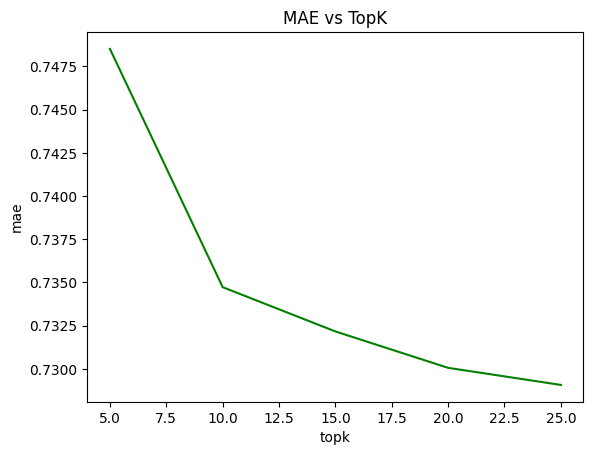

In [68]:
# Plotting MAE vs TopK Curve
plt.plot(KRange, mae_list, color='g')
plt.xlabel('topk')
plt.ylabel('mae')
plt.title('MAE vs TopK')

**Conclusion**

- The optimal Value of topk selected is 20
- **mse@k=20** : 0.869, **mae@k=20** : 0.730

## Hybrid Recommendation System

- The hybrid recommendation system employs a stacking approach that combines both user-based and item-based recommendation methodologies. This integration is achieved by calculating a weighted average of their individual ratings, effectively leveraging the strengths of each system to improve overall recommendation accuracy.

In [39]:
class HybridEngine:
    """Hybrid Engine using UB and IB Content Based Recommendation Systems"""
    def __init__(self, user_sim_matrix, 
                 item_sim_matrix, 
                 idx2user, 
                 idx2item,
                 train_df,
                 user_wt=0.1
                ):
        self.train_df = train_df
        self.user_wt = user_wt
        self.item_wt = 1 - self.user_wt

        # Initializing User based Engine
        self.ub_engine = UserBasedEngine(sim_matrix=user_sim_matrix,
                            idx2user = idx2user,
                            idx2item = idx2item,
                            train_df = train_df)

        # Initializing Item Based Engine
        self.ib_engine = ItemBasedEngine(sim_matrix=item_sim_matrix,
                            idx2user = idx2user,
                            idx2item = idx2item,
                            train_df = train_df)

    def predict(self, user_id, item_id, topk):
        # Predicting Individual ratings of both the systems
        ub_rating = self.ub_engine.predict(user_id, item_id, topk)
        ib_rating = self.ib_engine.predict(user_id, item_id, topk)

        # Taking weighted average for final rating\
        pred_rating = (self.user_wt * ub_rating) + (self.item_wt * ib_rating)
        return pred_rating

In [134]:
# Defining user weight list to select best user weight
user_wt_list = np.arange(0,1,0.1)

best_wt = None
best_mse = np.inf
topk = 20

# Evaluating HybridEngine using different weights to find the best set of parameters
for user_wt in user_wt_list:
    print(f"UB Weight : {user_wt} IB Weight : {1-user_wt}")
    hb_engine = HybridEngine(user_sim_matrix=user_sim_matrix,
                             item_sim_matrix=item_sim_matrix,
                             idx2user=idx2user, 
                             idx2item=idx2item,
                             train_df=train_df,
                             user_wt=user_wt)

    mse, mae = evaluate_engine(test_df = test_df_filtered,
                             topk = topk,
                             engine = hb_engine)
    if mse < best_mse:
        print(f"Best MSE Updated : {mse}")
        best_mse = mse 
        best_wt = user_wt

UB Weight : 0.0 IB Weight : 1.0
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Failed
6500/6832 Done | 0/6832 Failed
Removing Failed Indices
mse@k=20 : 0.8691914018792611, mae@k=20 : 0.730061854310166
Done
Best MSE Updated : 0.8691914018792611
UB Weight : 0.1 IB Weight : 0.9
Starting Inference
500/6832 Done | 0/6832 Failed
1000/6832 Done | 0/6832 Failed
1500/6832 Done | 0/6832 Failed
2000/6832 Done | 0/6832 Failed
2500/6832 Done | 0/6832 Failed
3000/6832 Done | 0/6832 Failed
3500/6832 Done | 0/6832 Failed
4000/6832 Done | 0/6832 Failed
4500/6832 Done | 0/6832 Failed
5000/6832 Done | 0/6832 Failed
5500/6832 Done | 0/6832 Failed
6000/6832 Done | 0/6832 Faile

In [135]:
print(f"Best UB Weight : {best_wt}")
print(f"Best MSE : {best_mse}")

Best UB Weight : 0.6000000000000001
Best MSE : 0.7294241890637869


**Conclusion**

Best params 
- User Weight = 0.6
- Item Weight = 0.4

## Final Interface for Recommender System

In [9]:
class HybridEngineInterface:
    """
    Final Recommendation System interface
    Based on Search Range, current location and user preference, suggest restaurants nearby
    """
    def __init__(self, user_sim_matrix, 
                 item_sim_matrix,
                 idx2user, 
                 idx2item,
                 search_range_in_miles,
                 user_wt,
                 train_df):
        """
        params:
            user_sim_matrix : user-user similarity matrix
            item_sim_matrix : item-item similarity matrix 
            idx2user : user-sim-matrix index to user_id mapping
            idx2item : item-sim-matrix index to item_id mapping
            search_range_in_miles : search radius in miles
            user_wt : User Based Engine weight
            train_df : training data
        """
        self.user_sim_matrix = user_sim_matrix
        self.item_sim_matrix = item_sim_matrix
        self.idx2user = idx2user
        self.idx2item = idx2item
        self.train_df = train_df 
        self.search_range_in_miles = search_range_in_miles 
        self.user_wt = user_wt 
        self.item_wt = 1 - user_wt

    def predict(self, user_id, lat, long , user_preference, topk, num_recommendations=5):
        """
        Method used to generate recommendations based on given data 
        params:
            user_id : input user id 
            lat : current latitude of the user
            long : current longitude of the user
            user_prefernece : User Preference from a selected user preference list
            topk : number of nearest neighbours to consider to rate the given item
            num_recommendations : number of recommendations to generate
        """
        # Filter training set based on given user preference
        filtered_df = self.train_df[self.train_df[user_preference] == 1]

        # Calculating search radius
        factor = self.search_range_in_miles / 69
        
        lat_min = lat - factor
        lat_max = lat + factor
        long_min = long - factor
        long_max = long + factor

        filtered_df = filtered_df[(filtered_df.latitude>=lat_min)&(filtered_df.latitude<=lat_max)&(filtered_df.longitude<=long_max)&(filtered_df.longitude>=long_min)]

        if filtered_df.shape[0] == 0:
            raise Exception(f"No Restaurants found within {self.search_range_in_miles} range")

        filtered_items = filtered_df.business_id.unique()
        ratings = []

        hb_engine = HybridEngine(user_sim_matrix=self.user_sim_matrix,
                             item_sim_matrix=self.item_sim_matrix,
                             idx2user=self.idx2user, 
                             idx2item=self.idx2item,
                             train_df=self.train_df,
                             user_wt=self.user_wt)
        for item in filtered_items:
            ratings.append(hb_engine.predict(user_id, item, topk))


        rec_df = pd.DataFrame({
            "item_id" : filtered_items, 
            "rating" : ratings
        })

        rec_df = rec_df.sort_values(by='rating', ascending=False)
        return rec_df.head(num_recommendations)

In [15]:
# Finding Unique Categories/User Preference
categories = []
for idx,row in train_df.iterrows():
    try:
        cat = row['categories'].split(', ')
    except Exception as e:
        continue
    for _ in cat:
        if _ not in categories:
            categories.append(_)

In [16]:
cat_list = []
for idx,row in train_df.iterrows():

    _ = [0] * len(categories)
    cat = row['categories']
    if cat is None:
        cat_list.append(_)
    else:
        cat = cat.split(', ')
        for c in cat:
            index = categories.index(c)
            _[index] = 1
        cat_list.append(_)

In [17]:
# Creating a dataframe for the categories
cat_df = pd.DataFrame(cat_list, columns=categories)

In [18]:
cat_df.head()

,Restaurants,Sushi Bars,Japanese,Bubble Tea,Taiwanese,Food,Bars,Nightlife,American (New),Gastropubs,...,Behavior Analysts,Trivia Hosts,Wallpapering,Clock Repair,Nanny Services,Private Schools,Audio/Visual Equipment Rental,Ceremonial Clothing,DUI Law,Hunting & Fishing Supplies
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Fining top30 Categories
freq_df = cat_df.sum().reset_index()
freq_df.rename(columns={'index' : 'categories', 0 : 'frequency'}, inplace=True)
freq_df = freq_df.sort_values(by='frequency', ascending=False)
top_k_cat = freq_df.head(30).categories.tolist()
top_k_cat

['Restaurants',
 'Food',
 'Nightlife',
 'Bars',
 'American (New)',
 'Breakfast & Brunch',
 'American (Traditional)',
 'Sandwiches',
 'Coffee & Tea',
 'Italian',
 'Pizza',
 'Shopping',
 'Specialty Food',
 'Chinese',
 'Event Planning & Services',
 'Desserts',
 'Cocktail Bars',
 'Seafood',
 'Pubs',
 'Mexican',
 'Wine & Spirits',
 'Beer',
 'Arts & Entertainment',
 'Cafes',
 'Bakeries',
 'Burgers',
 'Asian Fusion',
 'Vegetarian',
 'Japanese',
 'Salad']

In [20]:
with open(os.path.join(data_dir,'topK_categories.json'), 'w') as f:
    json.dump(top_k_cat, f)

In [21]:
combined_train_df = pd.concat([train_df, cat_df],axis=1)

In [22]:
combined_train_df

,review_id,user_id,business_id,user_rating,useful,funny,cool,text,date,name,...,Behavior Analysts,Trivia Hosts,Wallpapering,Clock Repair,Nanny Services,Private Schools,Audio/Visual Equipment Rental,Ceremonial Clothing,DUI Law,Hunting & Fishing Supplies
0,LEGT4hPIyEVMzy4HUROtoQ,-1MF2tosrw2WcCxeVNk81Q,9c7MUiE6VI8NesjPdj5FkA,3,4,0,1,A coworker and I stopped by here for an aftern...,2017-12-13 22:58:16,Bubblefish,...,0,0,0,0,0,0,0,0,0,0
1,QvoAHbml7mkqFrx9K18h2Q,-1MF2tosrw2WcCxeVNk81Q,1OfhM-ZKvcpxyxptCCzEwA,4,4,0,0,Stopped by here for happy hour and was fairly ...,2017-08-01 22:47:11,Independence Beer Garden,...,0,0,0,0,0,0,0,0,0,0
2,1StG62rGn6CQSa0VGYYX_Q,-1MF2tosrw2WcCxeVNk81Q,5Qz7TJFXhm8Mjc8xzoSV5Q,5,8,2,3,I'm drifting in and out of food coma as I writ...,2018-06-08 23:55:36,Picanha Brazilian Steakhouse,...,0,0,0,0,0,0,0,0,0,0
3,BrOC1DBY85kVMcBAIp6PWA,-1MF2tosrw2WcCxeVNk81Q,SVV1VmybJGXGge6nFuHy_A,3,2,1,1,I ordered a gift set from William-Sonoma which...,2019-02-07 18:43:04,Williams-Sonoma,...,0,0,0,0,0,0,0,0,0,0
4,1j-sybsKsFoHPW0D0VgvsA,-1MF2tosrw2WcCxeVNk81Q,waafKhA-LtJSZXlECyfEXw,5,7,3,3,"I am a foodie at heart, so I want to try this ...",2017-08-18 22:18:00,New York Gyro Halal Food Cart,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240459,jTPCx0xogcvWYI72tX205Q,zzBhA0M7NNBMYoWj48h53A,hkirr3WzSTx2d9cdP_NKSQ,5,0,0,0,Best falafel in Philadelphia. This place has b...,2016-12-19 02:17:39,Mama's Vegetarian,...,0,0,0,0,0,0,0,0,0,0
240460,WnmioStZIfmpBOgrHakLMg,zzBhA0M7NNBMYoWj48h53A,0IEn6AxLNFfdfuwd2bQlbQ,1,0,0,0,"i use to love this place, but now night time i...",2011-03-11 19:23:26,Golden Empress Garden,...,0,0,0,0,0,0,0,0,0,0
240461,WnmioStZIfmpBOgrHakLMg,zzBhA0M7NNBMYoWj48h53A,0IEn6AxLNFfdfuwd2bQlbQ,1,0,0,0,"i use to love this place, but now night time i...",2011-03-11 19:23:26,Golden Empress Garden,...,0,0,0,0,0,0,0,0,0,0
240462,N8TBI4eoLXlszLfQbV4CMw,zzBhA0M7NNBMYoWj48h53A,EPMHuTHu46B123ivRIZ-Xg,5,0,0,0,I don't know how this place does it. Best food...,2016-12-19 02:29:21,Magic Carpet,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Saving the combined dataframe with separate categories
combined_train_df.to_json(os.path.join(data_dir, 'train_df_with_cat.json'))

In [37]:
# Intializing the Hybrid Recommendation System Interface
best_wt = 0.6
interface_engine = HybridEngineInterface(
    user_sim_matrix=user_sim_matrix, 
    item_sim_matrix=item_sim_matrix,
    idx2user=idx2user, 
    idx2item=idx2item,
    search_range_in_miles=3,
    user_wt=best_wt,
    train_df=combined_train_df
)

In [40]:
# Generating Recommendations
preds = interface_engine.predict(user_id = 'TVN3qoXU0-sateboutdCZg',
                         lat = 39.958211,
                         long = -75.173137,
                         user_preference  = 'Italian',
                         topk=20
                        )
preds.head()

,item_id,rating
253,t5n5IBvXYG55xXrq6hga3Q,4.640418
290,TVe1FyolMt9xjBtY7oMTOQ,4.604390
44,6085NRg7QH3vXpc50F4UHQ,4.599762
255,3Ue1baQZeGqo2bOksGpQhg,4.581118
3,ndVqbK8tlQSZM63rajPkBQ,4.562587


In [168]:
for idx,row in preds.iterrows():
    print(train_df[train_df.business_id == row['item_id']].text.tolist())
    print(train_df[train_df.business_id == row['item_id']].item_rating.tolist())

    print("##########")

["Ok, I know it's a private club but I expect you can find someone to get you in. And getting in is half the fun. You wait outside until the red neon sign goes on. Then you enter a very small foyer with a black door at the other side that has a horizontal slot. It flips open and the mysterious eyes on the other side ask to see your membership card. (Think prohibition speak easy) \nThe door opens and you enter the throw back era of the 40s and 50s. It's a small bar with comfortable stools and Formica tables. There is a dignified painting of Filippo Palizzi behind a vintage wooden bar, a clock that hasn't worked in years. \nBut the food ! Oh the Italian food, how good.... really good it is. Everything is excellent, the pasta, the bread, the lamb chops and the Braciola... like mother made. \nAnd you must try the homemade Spumoni to end the evening. \nI forgot to mention earlier, Gabriella makes the consummate cocktail.", 'Delicious! The food is inventive and well execute.  They don\'t fal